In [1]:
import os
os.environ["KMP_DUPLICATE_LIB_OK"] = "TRUE"

In [2]:
from train import *
from utils import *
from data_load import *

In [3]:
from torchvision import models
from torch import nn
import torch
import torch.optim as optim
import random
from PIL import Image
import matplotlib.pyplot as plt


In [4]:
!nvidia-smi

Thu Dec 12 18:36:22 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 561.03                 Driver Version: 561.03         CUDA Version: 12.6     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                  Driver-Model | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3050 ...  WDDM  |   00000000:01:00.0 Off |                  N/A |
| N/A   62C    P8              7W /   45W |      74MiB /   4096MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [5]:
if torch.cuda.is_available():
    print(f"CUDA is available. Using GPU: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available. Using CPU.")
    
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Device used : {device}")

CUDA is available. Using GPU: NVIDIA GeForce RTX 3050 Ti Laptop GPU
Device used : cuda


## Load Datasets

In [6]:
# Définir le chemin du dataset
train_dir = '../SF-MASK-dataset/train'
test_dir = '../SF-MASK-dataset/test'

# Compter les images dans chaque sous-dossier
train_compliant = len(os.listdir(os.path.join(train_dir, 'compliant')))
train_non_compliant = len(os.listdir(os.path.join(train_dir, 'non-compliant')))
test_compliant = len(os.listdir(os.path.join(test_dir, 'compliant')))
test_non_compliant = len(os.listdir(os.path.join(test_dir, 'non-compliant')))

print(f"Training dataset: Compliant: {train_compliant}, Non-compliant: {train_non_compliant}")
print(f"Test dataset: Compliant: {test_compliant}, Non-compliant: {test_non_compliant}")

Training dataset: Compliant: 21384, Non-compliant: 15772
Test dataset: Compliant: 3622, Non-compliant: 5048


In [7]:
output_dir_train = "../SF-MASK-dataset-padded/train"
output_dir_test = "../SF-MASK-dataset-padded/test"

In [8]:
# # Apply padding to the train and test folders
# pad_and_resize(train_dir, output_dir_train)
# pad_and_resize(test_dir, output_dir_test)

In [9]:
AUGMENT = True
train_dataset, train_subset, val_subset , test_subset, train_loader, val_loader, test_loader = get_dataloaders(
    train_dir=output_dir_train, 
    test_dir=output_dir_test, 
    augment=AUGMENT
)

print(f"We take {DATASET_PROPORTION*100}% of the entire dataset (size {len(train_dataset)})\n")
print(f"Train Subset: {len(train_subset)}, Val subset: {len(val_subset)}, Test subset: {len(test_subset)}")
print(f"Train Loader: {len(train_loader)}, Val Loader: {len(val_loader)}, Test Loader: {len(test_loader)}")

We take 10.0% of the entire dataset (size 37156)

Train Subset: 2972, Val subset: 743, Test subset: 867
Train Loader: 93, Val Loader: 24, Test Loader: 28


In [10]:
# Load datasets with 10% of the data
train_dataset, train_subset = load_dataset(data_dir=output_dir_train, proportion=0.1, augment=True)
test_dataset, test_subset = load_dataset(data_dir=output_dir_test, augment=False)

# Split train_subset into train and validation
train_subset, val_subset = split_train_val(train_subset)

# Create DataLoaders
train_loader = DataLoader(train_subset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_subset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_subset, batch_size=BATCH_SIZE, shuffle=False)

# Verify the sizes
print(f"Original Dataset Size: {len(train_dataset)}")
print(f"Reduced Train Subset Size: {len(train_subset)}")
print(f"Validation Subset Size: {len(val_subset)}")
print(f"Test Subset Size: {len(test_subset)}")

Original Dataset Size: 37156
Reduced Train Subset Size: 2972
Validation Subset Size: 743
Test Subset Size: 867


## Training

In [24]:
print(f"Using {DATASET_PROPORTION * 100}% of the entire dataset (size: {len(train_dataset)}) for K-Fold Cross-Validation\n")


Using 10.0% of the entire dataset (size: 37156) for K-Fold Cross-Validation



In [25]:
train_dataset.classes

['compliant', 'non-compliant']

In [26]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam  
epochs = 20
k_folds = 5
param_grid = {
    "learning_rate": [1e-4, 1e-5],
    "batch_size": [16, 32],
}
augment_strategies = [True]

results_file = "kfold_hyperparam_results.json"
model_class = models.mobilenet_v2


In [27]:
# Perform K-fold cross-validation with hyperparameter tuning
# Get current date and time
training_time = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
time_started = training_time.replace(" ", "_").replace(":", "-")

start_time = time.time()

kfold_results = kfold_with_hyperparam_tuning(
    model_class=model_class,
    original_dataset=train_dataset,
    dataset=train_subset,
    criterion=criterion,
    optimizer_class=optimizer,
    param_grid=param_grid,
    augment_strategies=augment_strategies,
    k_folds=k_folds,
    epochs=epochs,
    device=device,
    results_file = results_file,
)

end_time = time.time()
all_HT_training_time = end_time - start_time



Running K-fold cross-validation with hyperparameter tuning for mobilenet_v2...

2972 samples in the dataset = 37156/2972= 12.502018842530283%. 5-fold CV with 20 epochs per fold.

=== Running With Augmentation ===

Testing hyperparameters: {'batch_size': 16, 'learning_rate': 0.0001}

Fold 1/5 for {'batch_size': 16, 'learning_rate': 0.0001}
size of train_loader : 149, size of val_loader : 38
Training MobileNetV2 for 20 epochs...


c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Train Loss: 0.3704, Train Accuracy: 83.93%, Train F1: 0.8391, Val Loss: 0.2326, Val Accuracy: 90.08%, Val F1: 0.9006, Time: 55.64s
Epoch 2/20, Train Loss: 0.2317, Train Accuracy: 90.83%, Train F1: 0.9085, Val Loss: 0.2216, Val Accuracy: 90.92%, Val F1: 0.9094, Time: 40.60s
Epoch 3/20, Train Loss: 0.2107, Train Accuracy: 92.05%, Train F1: 0.9207, Val Loss: 0.2165, Val Accuracy: 91.09%, Val F1: 0.9110, Time: 40.96s
Epoch 4/20, Train Loss: 0.1914, Train Accuracy: 92.22%, Train F1: 0.9224, Val Loss: 0.2408, Val Accuracy: 91.09%, Val F1: 0.9111, Time: 41.35s
Epoch 5/20, Train Loss: 0.1677, Train Accuracy: 92.93%, Train F1: 0.9295, Val Loss: 0.1757, Val Accuracy: 91.76%, Val F1: 0.9176, Time: 40.34s
Epoch 6/20, Train Loss: 0.1528, Train Accuracy: 93.73%, Train F1: 0.9374, Val Loss: 0.1969, Val Accuracy: 92.77%, Val F1: 0.9272, Time: 41.37s
Epoch 7/20, Train Loss: 0.1447, Train Accuracy: 94.53%, Train F1: 0.9453, Val Loss: 0.1994, Val Accuracy: 92.61%, Val F1: 0.9263, Time: 40.96s

c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Train Loss: 0.3578, Train Accuracy: 84.22%, Train F1: 0.8422, Val Loss: 0.2377, Val Accuracy: 89.92%, Val F1: 0.8993, Time: 39.75s
Epoch 2/20, Train Loss: 0.2505, Train Accuracy: 90.11%, Train F1: 0.9015, Val Loss: 0.2102, Val Accuracy: 90.76%, Val F1: 0.9077, Time: 39.20s
Epoch 3/20, Train Loss: 0.2055, Train Accuracy: 91.75%, Train F1: 0.9178, Val Loss: 0.1929, Val Accuracy: 93.28%, Val F1: 0.9329, Time: 38.88s
Epoch 4/20, Train Loss: 0.2119, Train Accuracy: 91.46%, Train F1: 0.9148, Val Loss: 0.1598, Val Accuracy: 92.94%, Val F1: 0.9296, Time: 39.12s
Epoch 5/20, Train Loss: 0.1800, Train Accuracy: 92.85%, Train F1: 0.9286, Val Loss: 0.1686, Val Accuracy: 93.11%, Val F1: 0.9313, Time: 39.14s
Epoch 6/20, Train Loss: 0.1637, Train Accuracy: 93.61%, Train F1: 0.9362, Val Loss: 0.1407, Val Accuracy: 94.45%, Val F1: 0.9447, Time: 39.18s
Epoch 7/20, Train Loss: 0.1472, Train Accuracy: 94.36%, Train F1: 0.9438, Val Loss: 0.1297, Val Accuracy: 95.46%, Val F1: 0.9547, Time: 39.32s

c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


size of train_loader : 149, size of val_loader : 38
Training MobileNetV2 for 20 epochs...
Epoch 1/20, Train Loss: 0.3663, Train Accuracy: 83.89%, Train F1: 0.8392, Val Loss: 0.2599, Val Accuracy: 89.56%, Val F1: 0.8951, Time: 39.83s
Epoch 2/20, Train Loss: 0.2572, Train Accuracy: 89.11%, Train F1: 0.8913, Val Loss: 0.1915, Val Accuracy: 90.91%, Val F1: 0.9095, Time: 39.45s
Epoch 3/20, Train Loss: 0.2076, Train Accuracy: 91.72%, Train F1: 0.9173, Val Loss: 0.1873, Val Accuracy: 91.92%, Val F1: 0.9195, Time: 39.42s
Epoch 4/20, Train Loss: 0.1956, Train Accuracy: 92.01%, Train F1: 0.9203, Val Loss: 0.1749, Val Accuracy: 92.76%, Val F1: 0.9276, Time: 39.55s
Epoch 5/20, Train Loss: 0.1771, Train Accuracy: 93.02%, Train F1: 0.9303, Val Loss: 0.1832, Val Accuracy: 92.26%, Val F1: 0.9229, Time: 39.35s
Epoch 6/20, Train Loss: 0.1629, Train Accuracy: 93.82%, Train F1: 0.9383, Val Loss: 0.2008, Val Accuracy: 91.25%, Val F1: 0.9128, Time: 39.44s
Epoch 7/20, Train Loss: 0.1585, Train Accuracy: 94.7

c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


size of train_loader : 149, size of val_loader : 38
Training MobileNetV2 for 20 epochs...
Epoch 1/20, Train Loss: 0.3602, Train Accuracy: 83.85%, Train F1: 0.8384, Val Loss: 0.2220, Val Accuracy: 91.41%, Val F1: 0.9140, Time: 39.26s
Epoch 2/20, Train Loss: 0.2525, Train Accuracy: 89.40%, Train F1: 0.8943, Val Loss: 0.1811, Val Accuracy: 92.09%, Val F1: 0.9209, Time: 39.37s
Epoch 3/20, Train Loss: 0.2039, Train Accuracy: 91.63%, Train F1: 0.9165, Val Loss: 0.1658, Val Accuracy: 93.27%, Val F1: 0.9326, Time: 38.94s
Epoch 4/20, Train Loss: 0.1896, Train Accuracy: 92.14%, Train F1: 0.9215, Val Loss: 0.1875, Val Accuracy: 90.57%, Val F1: 0.9059, Time: 39.18s
Epoch 5/20, Train Loss: 0.1671, Train Accuracy: 93.19%, Train F1: 0.9320, Val Loss: 0.1688, Val Accuracy: 93.94%, Val F1: 0.9393, Time: 38.85s
Epoch 6/20, Train Loss: 0.1515, Train Accuracy: 94.03%, Train F1: 0.9403, Val Loss: 0.1434, Val Accuracy: 95.12%, Val F1: 0.9513, Time: 39.69s
Epoch 7/20, Train Loss: 0.1409, Train Accuracy: 94.6

c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


size of train_loader : 149, size of val_loader : 38
Training MobileNetV2 for 20 epochs...
Epoch 1/20, Train Loss: 0.3581, Train Accuracy: 85.28%, Train F1: 0.8529, Val Loss: 0.2436, Val Accuracy: 90.24%, Val F1: 0.9022, Time: 39.65s
Epoch 2/20, Train Loss: 0.2636, Train Accuracy: 89.15%, Train F1: 0.8916, Val Loss: 0.2224, Val Accuracy: 90.40%, Val F1: 0.9044, Time: 39.29s
Epoch 3/20, Train Loss: 0.2252, Train Accuracy: 90.50%, Train F1: 0.9052, Val Loss: 0.2024, Val Accuracy: 91.25%, Val F1: 0.9123, Time: 39.38s
Epoch 4/20, Train Loss: 0.1854, Train Accuracy: 92.89%, Train F1: 0.9291, Val Loss: 0.1877, Val Accuracy: 92.59%, Val F1: 0.9262, Time: 39.20s
Epoch 5/20, Train Loss: 0.1817, Train Accuracy: 92.77%, Train F1: 0.9278, Val Loss: 0.1754, Val Accuracy: 93.10%, Val F1: 0.9313, Time: 39.35s
Epoch 6/20, Train Loss: 0.1679, Train Accuracy: 93.27%, Train F1: 0.9328, Val Loss: 0.1578, Val Accuracy: 93.27%, Val F1: 0.9330, Time: 39.09s
Epoch 7/20, Train Loss: 0.1472, Train Accuracy: 93.9

c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Train Loss: 0.5465, Train Accuracy: 72.99%, Train F1: 0.7314, Val Loss: 0.4218, Val Accuracy: 81.68%, Val F1: 0.8163, Time: 39.26s
Epoch 2/20, Train Loss: 0.4093, Train Accuracy: 82.79%, Train F1: 0.8273, Val Loss: 0.3280, Val Accuracy: 86.72%, Val F1: 0.8675, Time: 39.53s
Epoch 3/20, Train Loss: 0.3450, Train Accuracy: 85.91%, Train F1: 0.8590, Val Loss: 0.2852, Val Accuracy: 89.08%, Val F1: 0.8913, Time: 40.14s
Epoch 4/20, Train Loss: 0.3126, Train Accuracy: 86.79%, Train F1: 0.8677, Val Loss: 0.2500, Val Accuracy: 90.42%, Val F1: 0.9042, Time: 39.48s
Epoch 5/20, Train Loss: 0.2709, Train Accuracy: 89.78%, Train F1: 0.8978, Val Loss: 0.2404, Val Accuracy: 91.09%, Val F1: 0.9108, Time: 39.30s
Epoch 6/20, Train Loss: 0.2657, Train Accuracy: 88.89%, Train F1: 0.8889, Val Loss: 0.2508, Val Accuracy: 90.92%, Val F1: 0.9095, Time: 39.61s
Epoch 7/20, Train Loss: 0.2492, Train Accuracy: 89.52%, Train F1: 0.8953, Val Loss: 0.2254, Val Accuracy: 90.25%, Val F1: 0.9028, Time: 39.38s

c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


size of train_loader : 149, size of val_loader : 38
Training MobileNetV2 for 20 epochs...
Epoch 1/20, Train Loss: 0.5448, Train Accuracy: 72.99%, Train F1: 0.7306, Val Loss: 0.4247, Val Accuracy: 81.18%, Val F1: 0.8108, Time: 39.68s
Epoch 2/20, Train Loss: 0.4061, Train Accuracy: 82.63%, Train F1: 0.8254, Val Loss: 0.3367, Val Accuracy: 86.39%, Val F1: 0.8636, Time: 39.57s
Epoch 3/20, Train Loss: 0.3438, Train Accuracy: 85.78%, Train F1: 0.8577, Val Loss: 0.2823, Val Accuracy: 88.91%, Val F1: 0.8891, Time: 40.34s
Epoch 4/20, Train Loss: 0.3190, Train Accuracy: 86.71%, Train F1: 0.8672, Val Loss: 0.2854, Val Accuracy: 88.40%, Val F1: 0.8842, Time: 39.19s
Epoch 5/20, Train Loss: 0.2732, Train Accuracy: 88.73%, Train F1: 0.8873, Val Loss: 0.2479, Val Accuracy: 89.75%, Val F1: 0.8977, Time: 39.51s
Epoch 6/20, Train Loss: 0.2572, Train Accuracy: 89.86%, Train F1: 0.8987, Val Loss: 0.2297, Val Accuracy: 90.25%, Val F1: 0.9024, Time: 39.38s
Epoch 7/20, Train Loss: 0.2503, Train Accuracy: 89.8

c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


size of train_loader : 149, size of val_loader : 38
Training MobileNetV2 for 20 epochs...
Epoch 1/20, Train Loss: 0.5409, Train Accuracy: 73.72%, Train F1: 0.7279, Val Loss: 0.4357, Val Accuracy: 79.63%, Val F1: 0.7944, Time: 39.53s
Epoch 2/20, Train Loss: 0.4069, Train Accuracy: 82.38%, Train F1: 0.8229, Val Loss: 0.3388, Val Accuracy: 86.03%, Val F1: 0.8606, Time: 39.39s
Epoch 3/20, Train Loss: 0.3449, Train Accuracy: 86.04%, Train F1: 0.8601, Val Loss: 0.2808, Val Accuracy: 88.22%, Val F1: 0.8824, Time: 39.19s
Epoch 4/20, Train Loss: 0.2979, Train Accuracy: 88.06%, Train F1: 0.8808, Val Loss: 0.2730, Val Accuracy: 89.39%, Val F1: 0.8943, Time: 39.50s
Epoch 5/20, Train Loss: 0.2888, Train Accuracy: 88.86%, Train F1: 0.8886, Val Loss: 0.2647, Val Accuracy: 89.06%, Val F1: 0.8908, Time: 39.75s
Epoch 6/20, Train Loss: 0.2587, Train Accuracy: 89.36%, Train F1: 0.8937, Val Loss: 0.2353, Val Accuracy: 89.73%, Val F1: 0.8976, Time: 40.33s
Epoch 7/20, Train Loss: 0.2392, Train Accuracy: 91.1

c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Train Loss: 0.5304, Train Accuracy: 74.77%, Train F1: 0.7448, Val Loss: 0.4108, Val Accuracy: 80.64%, Val F1: 0.8034, Time: 39.24s
Epoch 2/20, Train Loss: 0.4017, Train Accuracy: 83.39%, Train F1: 0.8328, Val Loss: 0.3185, Val Accuracy: 87.21%, Val F1: 0.8715, Time: 39.20s
Epoch 3/20, Train Loss: 0.3393, Train Accuracy: 86.12%, Train F1: 0.8614, Val Loss: 0.2758, Val Accuracy: 89.06%, Val F1: 0.8902, Time: 39.44s
Epoch 4/20, Train Loss: 0.2905, Train Accuracy: 88.18%, Train F1: 0.8818, Val Loss: 0.2396, Val Accuracy: 91.08%, Val F1: 0.9105, Time: 39.30s
Epoch 5/20, Train Loss: 0.2742, Train Accuracy: 88.44%, Train F1: 0.8844, Val Loss: 0.2435, Val Accuracy: 89.23%, Val F1: 0.8915, Time: 39.42s
Epoch 6/20, Train Loss: 0.2468, Train Accuracy: 90.24%, Train F1: 0.9024, Val Loss: 0.2132, Val Accuracy: 91.41%, Val F1: 0.9140, Time: 39.62s
Epoch 7/20, Train Loss: 0.2510, Train Accuracy: 90.33%, Train F1: 0.9034, Val Loss: 0.1961, Val Accuracy: 92.26%, Val F1: 0.9227, Time: 39.47s

c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Train Loss: 0.5375, Train Accuracy: 73.38%, Train F1: 0.7282, Val Loss: 0.4480, Val Accuracy: 79.29%, Val F1: 0.7922, Time: 39.15s
Epoch 2/20, Train Loss: 0.3968, Train Accuracy: 84.06%, Train F1: 0.8402, Val Loss: 0.3372, Val Accuracy: 86.03%, Val F1: 0.8609, Time: 39.25s
Epoch 3/20, Train Loss: 0.3213, Train Accuracy: 87.22%, Train F1: 0.8722, Val Loss: 0.2879, Val Accuracy: 88.89%, Val F1: 0.8896, Time: 39.17s
Epoch 4/20, Train Loss: 0.3012, Train Accuracy: 88.18%, Train F1: 0.8820, Val Loss: 0.2748, Val Accuracy: 88.89%, Val F1: 0.8895, Time: 39.62s
Epoch 5/20, Train Loss: 0.2833, Train Accuracy: 88.06%, Train F1: 0.8805, Val Loss: 0.2452, Val Accuracy: 88.72%, Val F1: 0.8874, Time: 38.37s
Epoch 6/20, Train Loss: 0.2613, Train Accuracy: 89.28%, Train F1: 0.8929, Val Loss: 0.2389, Val Accuracy: 88.38%, Val F1: 0.8846, Time: 40.19s
Epoch 7/20, Train Loss: 0.2509, Train Accuracy: 90.29%, Train F1: 0.9029, Val Loss: 0.2248, Val Accuracy: 90.57%, Val F1: 0.9057, Time: 39.59s

c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Train Loss: 0.3668, Train Accuracy: 83.80%, Train F1: 0.8380, Val Loss: 0.2478, Val Accuracy: 89.58%, Val F1: 0.8964, Time: 38.40s
Epoch 2/20, Train Loss: 0.2362, Train Accuracy: 90.32%, Train F1: 0.9033, Val Loss: 0.2301, Val Accuracy: 90.59%, Val F1: 0.9061, Time: 38.07s
Epoch 3/20, Train Loss: 0.2106, Train Accuracy: 91.75%, Train F1: 0.9177, Val Loss: 0.2063, Val Accuracy: 91.76%, Val F1: 0.9180, Time: 38.34s
Epoch 4/20, Train Loss: 0.1704, Train Accuracy: 92.97%, Train F1: 0.9299, Val Loss: 0.1770, Val Accuracy: 93.45%, Val F1: 0.9347, Time: 38.78s
Epoch 5/20, Train Loss: 0.1578, Train Accuracy: 93.31%, Train F1: 0.9332, Val Loss: 0.1874, Val Accuracy: 91.76%, Val F1: 0.9179, Time: 38.62s
Epoch 6/20, Train Loss: 0.1379, Train Accuracy: 94.07%, Train F1: 0.9408, Val Loss: 0.1735, Val Accuracy: 93.28%, Val F1: 0.9331, Time: 38.80s
Epoch 7/20, Train Loss: 0.1348, Train Accuracy: 94.95%, Train F1: 0.9496, Val Loss: 0.2206, Val Accuracy: 93.11%, Val F1: 0.9312, Time: 38.69s

c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


size of train_loader : 75, size of val_loader : 19
Training MobileNetV2 for 20 epochs...
Epoch 1/20, Train Loss: 0.3642, Train Accuracy: 83.93%, Train F1: 0.8392, Val Loss: 0.2376, Val Accuracy: 90.08%, Val F1: 0.9007, Time: 38.58s
Epoch 2/20, Train Loss: 0.2402, Train Accuracy: 90.49%, Train F1: 0.9052, Val Loss: 0.2118, Val Accuracy: 91.93%, Val F1: 0.9195, Time: 39.12s
Epoch 3/20, Train Loss: 0.2155, Train Accuracy: 91.50%, Train F1: 0.9152, Val Loss: 0.1865, Val Accuracy: 93.28%, Val F1: 0.9329, Time: 38.38s
Epoch 4/20, Train Loss: 0.1812, Train Accuracy: 92.89%, Train F1: 0.9291, Val Loss: 0.1748, Val Accuracy: 93.95%, Val F1: 0.9393, Time: 39.11s
Epoch 5/20, Train Loss: 0.1696, Train Accuracy: 93.10%, Train F1: 0.9311, Val Loss: 0.1595, Val Accuracy: 92.77%, Val F1: 0.9279, Time: 38.42s
Epoch 6/20, Train Loss: 0.1510, Train Accuracy: 94.19%, Train F1: 0.9421, Val Loss: 0.1565, Val Accuracy: 93.11%, Val F1: 0.9308, Time: 38.78s
Epoch 7/20, Train Loss: 0.1498, Train Accuracy: 94.36

c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


size of train_loader : 75, size of val_loader : 19
Training MobileNetV2 for 20 epochs...
Epoch 1/20, Train Loss: 0.3693, Train Accuracy: 83.35%, Train F1: 0.8335, Val Loss: 0.2411, Val Accuracy: 90.24%, Val F1: 0.9026, Time: 39.61s
Epoch 2/20, Train Loss: 0.2443, Train Accuracy: 89.78%, Train F1: 0.8980, Val Loss: 0.1991, Val Accuracy: 91.41%, Val F1: 0.9145, Time: 38.58s
Epoch 3/20, Train Loss: 0.2106, Train Accuracy: 91.55%, Train F1: 0.9157, Val Loss: 0.1675, Val Accuracy: 93.77%, Val F1: 0.9376, Time: 38.57s
Epoch 4/20, Train Loss: 0.1895, Train Accuracy: 93.02%, Train F1: 0.9303, Val Loss: 0.1740, Val Accuracy: 91.41%, Val F1: 0.9138, Time: 38.74s
Epoch 5/20, Train Loss: 0.1668, Train Accuracy: 93.61%, Train F1: 0.9361, Val Loss: 0.1721, Val Accuracy: 92.42%, Val F1: 0.9244, Time: 40.48s
Epoch 6/20, Train Loss: 0.1451, Train Accuracy: 94.87%, Train F1: 0.9488, Val Loss: 0.1509, Val Accuracy: 93.94%, Val F1: 0.9396, Time: 38.30s
Epoch 7/20, Train Loss: 0.1333, Train Accuracy: 94.83

c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Train Loss: 0.3778, Train Accuracy: 83.39%, Train F1: 0.8337, Val Loss: 0.2427, Val Accuracy: 90.07%, Val F1: 0.9006, Time: 38.71s
Epoch 2/20, Train Loss: 0.2432, Train Accuracy: 89.78%, Train F1: 0.8979, Val Loss: 0.1644, Val Accuracy: 93.60%, Val F1: 0.9361, Time: 37.74s
Epoch 3/20, Train Loss: 0.2154, Train Accuracy: 91.59%, Train F1: 0.9161, Val Loss: 0.1776, Val Accuracy: 92.42%, Val F1: 0.9242, Time: 39.18s
Epoch 4/20, Train Loss: 0.1623, Train Accuracy: 93.82%, Train F1: 0.9382, Val Loss: 0.1772, Val Accuracy: 92.93%, Val F1: 0.9293, Time: 38.51s
Epoch 5/20, Train Loss: 0.1508, Train Accuracy: 93.61%, Train F1: 0.9361, Val Loss: 0.1528, Val Accuracy: 94.11%, Val F1: 0.9411, Time: 38.52s
Epoch 6/20, Train Loss: 0.1530, Train Accuracy: 94.03%, Train F1: 0.9403, Val Loss: 0.1609, Val Accuracy: 93.43%, Val F1: 0.9342, Time: 38.52s
Epoch 7/20, Train Loss: 0.1237, Train Accuracy: 94.79%, Train F1: 0.9480, Val Loss: 0.1715, Val Accuracy: 93.60%, Val F1: 0.9358, Time: 38.61s

c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Train Loss: 0.3881, Train Accuracy: 82.17%, Train F1: 0.8225, Val Loss: 0.2423, Val Accuracy: 88.55%, Val F1: 0.8860, Time: 38.93s
Epoch 2/20, Train Loss: 0.2418, Train Accuracy: 90.33%, Train F1: 0.9035, Val Loss: 0.2348, Val Accuracy: 89.39%, Val F1: 0.8945, Time: 38.43s
Epoch 3/20, Train Loss: 0.1931, Train Accuracy: 91.46%, Train F1: 0.9148, Val Loss: 0.1964, Val Accuracy: 92.59%, Val F1: 0.9263, Time: 38.29s
Epoch 4/20, Train Loss: 0.1987, Train Accuracy: 91.63%, Train F1: 0.9164, Val Loss: 0.2012, Val Accuracy: 90.57%, Val F1: 0.9064, Time: 39.06s
Epoch 5/20, Train Loss: 0.1750, Train Accuracy: 92.94%, Train F1: 0.9295, Val Loss: 0.1808, Val Accuracy: 91.08%, Val F1: 0.9110, Time: 37.69s
Epoch 6/20, Train Loss: 0.1451, Train Accuracy: 93.73%, Train F1: 0.9374, Val Loss: 0.1680, Val Accuracy: 92.42%, Val F1: 0.9247, Time: 38.54s
Epoch 7/20, Train Loss: 0.1421, Train Accuracy: 94.79%, Train F1: 0.9479, Val Loss: 0.1625, Val Accuracy: 93.77%, Val F1: 0.9377, Time: 38.55s

c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


size of train_loader : 75, size of val_loader : 19
Training MobileNetV2 for 20 epochs...
Epoch 1/20, Train Loss: 0.6392, Train Accuracy: 63.95%, Train F1: 0.6320, Val Loss: 0.5102, Val Accuracy: 76.30%, Val F1: 0.7640, Time: 38.60s
Epoch 2/20, Train Loss: 0.4676, Train Accuracy: 79.34%, Train F1: 0.7932, Val Loss: 0.4045, Val Accuracy: 81.34%, Val F1: 0.8138, Time: 38.64s
Epoch 3/20, Train Loss: 0.3874, Train Accuracy: 84.60%, Train F1: 0.8457, Val Loss: 0.3485, Val Accuracy: 85.71%, Val F1: 0.8571, Time: 38.58s
Epoch 4/20, Train Loss: 0.3363, Train Accuracy: 86.16%, Train F1: 0.8616, Val Loss: 0.2939, Val Accuracy: 88.40%, Val F1: 0.8840, Time: 38.68s
Epoch 5/20, Train Loss: 0.3077, Train Accuracy: 87.17%, Train F1: 0.8717, Val Loss: 0.2821, Val Accuracy: 89.24%, Val F1: 0.8928, Time: 39.24s
Epoch 6/20, Train Loss: 0.2819, Train Accuracy: 88.18%, Train F1: 0.8818, Val Loss: 0.2645, Val Accuracy: 89.92%, Val F1: 0.8994, Time: 38.90s
Epoch 7/20, Train Loss: 0.2667, Train Accuracy: 88.68

c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


size of train_loader : 75, size of val_loader : 19
Training MobileNetV2 for 20 epochs...
Epoch 1/20, Train Loss: 0.5581, Train Accuracy: 72.49%, Train F1: 0.7239, Val Loss: 0.4674, Val Accuracy: 80.84%, Val F1: 0.8085, Time: 38.14s
Epoch 2/20, Train Loss: 0.4334, Train Accuracy: 81.03%, Train F1: 0.8087, Val Loss: 0.3730, Val Accuracy: 85.55%, Val F1: 0.8543, Time: 38.33s
Epoch 3/20, Train Loss: 0.3653, Train Accuracy: 85.53%, Train F1: 0.8550, Val Loss: 0.3118, Val Accuracy: 88.07%, Val F1: 0.8803, Time: 37.73s
Epoch 4/20, Train Loss: 0.3115, Train Accuracy: 87.84%, Train F1: 0.8785, Val Loss: 0.2866, Val Accuracy: 88.57%, Val F1: 0.8858, Time: 39.01s
Epoch 5/20, Train Loss: 0.2823, Train Accuracy: 89.15%, Train F1: 0.8915, Val Loss: 0.2797, Val Accuracy: 87.39%, Val F1: 0.8742, Time: 38.31s
Epoch 6/20, Train Loss: 0.2806, Train Accuracy: 88.64%, Train F1: 0.8865, Val Loss: 0.2456, Val Accuracy: 90.25%, Val F1: 0.9026, Time: 38.20s
Epoch 7/20, Train Loss: 0.2548, Train Accuracy: 89.36

c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


size of train_loader : 75, size of val_loader : 19
Training MobileNetV2 for 20 epochs...
Epoch 1/20, Train Loss: 0.6259, Train Accuracy: 64.84%, Train F1: 0.6440, Val Loss: 0.4939, Val Accuracy: 77.78%, Val F1: 0.7778, Time: 38.15s
Epoch 2/20, Train Loss: 0.4601, Train Accuracy: 79.23%, Train F1: 0.7914, Val Loss: 0.4010, Val Accuracy: 83.67%, Val F1: 0.8367, Time: 38.41s
Epoch 3/20, Train Loss: 0.3870, Train Accuracy: 83.98%, Train F1: 0.8392, Val Loss: 0.3411, Val Accuracy: 87.21%, Val F1: 0.8723, Time: 38.17s
Epoch 4/20, Train Loss: 0.3271, Train Accuracy: 87.05%, Train F1: 0.8705, Val Loss: 0.3066, Val Accuracy: 88.05%, Val F1: 0.8808, Time: 38.53s
Epoch 5/20, Train Loss: 0.2951, Train Accuracy: 88.44%, Train F1: 0.8842, Val Loss: 0.2728, Val Accuracy: 89.56%, Val F1: 0.8959, Time: 38.23s
Epoch 6/20, Train Loss: 0.2782, Train Accuracy: 88.69%, Train F1: 0.8868, Val Loss: 0.2602, Val Accuracy: 88.72%, Val F1: 0.8874, Time: 38.82s
Epoch 7/20, Train Loss: 0.2647, Train Accuracy: 89.11

c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Train Loss: 0.5695, Train Accuracy: 70.90%, Train F1: 0.7102, Val Loss: 0.4652, Val Accuracy: 80.13%, Val F1: 0.7997, Time: 38.35s
Epoch 2/20, Train Loss: 0.4450, Train Accuracy: 80.49%, Train F1: 0.8042, Val Loss: 0.3750, Val Accuracy: 84.18%, Val F1: 0.8396, Time: 38.21s
Epoch 3/20, Train Loss: 0.3722, Train Accuracy: 84.48%, Train F1: 0.8445, Val Loss: 0.3225, Val Accuracy: 87.88%, Val F1: 0.8782, Time: 38.36s
Epoch 4/20, Train Loss: 0.3233, Train Accuracy: 86.96%, Train F1: 0.8694, Val Loss: 0.2801, Val Accuracy: 89.73%, Val F1: 0.8971, Time: 38.18s
Epoch 5/20, Train Loss: 0.2980, Train Accuracy: 87.85%, Train F1: 0.8784, Val Loss: 0.2688, Val Accuracy: 90.40%, Val F1: 0.9034, Time: 38.26s
Epoch 6/20, Train Loss: 0.2762, Train Accuracy: 88.23%, Train F1: 0.8822, Val Loss: 0.2504, Val Accuracy: 90.74%, Val F1: 0.9070, Time: 38.18s
Epoch 7/20, Train Loss: 0.2663, Train Accuracy: 89.74%, Train F1: 0.8974, Val Loss: 0.2468, Val Accuracy: 89.39%, Val F1: 0.8934, Time: 38.40s

c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch 1/20, Train Loss: 0.5699, Train Accuracy: 70.77%, Train F1: 0.7090, Val Loss: 0.4945, Val Accuracy: 77.44%, Val F1: 0.7729, Time: 38.56s
Epoch 2/20, Train Loss: 0.4484, Train Accuracy: 80.40%, Train F1: 0.8026, Val Loss: 0.4137, Val Accuracy: 81.14%, Val F1: 0.8114, Time: 38.45s
Epoch 3/20, Train Loss: 0.3731, Train Accuracy: 84.31%, Train F1: 0.8427, Val Loss: 0.3466, Val Accuracy: 85.86%, Val F1: 0.8579, Time: 38.38s
Epoch 4/20, Train Loss: 0.3340, Train Accuracy: 87.17%, Train F1: 0.8716, Val Loss: 0.3181, Val Accuracy: 87.04%, Val F1: 0.8706, Time: 38.72s
Epoch 5/20, Train Loss: 0.2967, Train Accuracy: 87.85%, Train F1: 0.8785, Val Loss: 0.2744, Val Accuracy: 89.23%, Val F1: 0.8927, Time: 38.16s
Epoch 6/20, Train Loss: 0.2762, Train Accuracy: 88.52%, Train F1: 0.8851, Val Loss: 0.2664, Val Accuracy: 89.90%, Val F1: 0.8994, Time: 38.16s
Epoch 7/20, Train Loss: 0.2613, Train Accuracy: 89.28%, Train F1: 0.8928, Val Loss: 0.2483, Val Accuracy: 89.73%, Val F1: 0.8977, Time: 38.55s

In [29]:
kfold_results

[{'all_total_time_kfold': 3126.6639420986176,
  'params': {'batch_size': 16, 'learning_rate': 0.0001},
  'augment': True,
  'fold_results': [{'fold': 1,
    'model_save_path': 'training/MobileNetV2_lr_0.0001_bs_16_aug_True_fold_1.pth',
    'total_time_training': 510.82603883743286,
    'val_accuracy': 92.60504201680672,
    'training_metrics': [{'epoch': 1,
      'train_loss': 0.370414090936616,
      'val_loss': 0.23258713574001663,
      'train_accuracy': 83.92932267564157,
      'val_accuracy': 90.08403361344538,
      'train_f1': 0.83912017324483,
      'val_f1': 0.9005532320407874,
      'time': 55.6391224861145,
      'learning_rate': 0.0001},
     {'epoch': 2,
      'train_loss': 0.23169244203291484,
      'val_loss': 0.22163171845635302,
      'train_accuracy': 90.8287757677745,
      'val_accuracy': 90.92436974789916,
      'train_f1': 0.9084682032399402,
      'val_f1': 0.90943920234637,
      'time': 40.60197997093201,
      'learning_rate': 0.0001},
     {'epoch': 3,
      

In [32]:
metrics = {
    "model_name": initialize_model(model_class, num_classes=2, device=device).__class__.__name__, #"MobileNetV2"
    "device": str(device),
    "time started": time_started,
    "total hyperparameter training time": "27min",
    "dataset_info": {
        "original_train_dataset_size": len(train_dataset),
        "proportion_used": DATASET_PROPORTION,
        "train_subset_size": len(train_subset),
        "validation_subset_size": len(val_subset),
        "test_subset_size": len(test_subset),
    },
    "training_parameters": {
        "kfold": k_folds,
        "epochs": epochs,
    },
    "kfold_results": kfold_results,
}

# Save results after every parameter combination
save_metrics_to_json(kfold_results, results_file)


Metrics saved to kfold_hyperparam_results.json


# Load model to test

In [12]:
# Load the pre-trained MobileNetV2 model
model = models.mobilenet_v2(pretrained=True)

# Modify the classifier for binary classification (2 classes: mask/no mask)
model.classifier[1] = torch.nn.Linear(model.classifier[1].in_features, 2)

# Load your trained model weights
# model_save_path = "results/mobilenetv2_trained_lr_0.0001_bs_16.pth" 
model_save_path = "results_12_12/best_model_95.45_lr_0.0001_bs_32_aug_True_fold_5.pth"
model.load_state_dict(torch.load(model_save_path, map_location=device), strict=False)

# Move the model to the appropriate device (GPU or CPU)
model = model.to(device)

# Set the model to evaluation mode
model.eval()

print(f"Model loaded and set to evaluation mode on device: {device}")

c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\Sinbad\anaconda3\envs\sf-mask-detector\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
C:\Users\Sinbad\AppData\Local\Temp\ipykernel_11576\2020660752.py:10: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling 

Model loaded and set to evaluation mode on device: cuda


## Random Image Testing 

Prediction: non-compliant (96.30% confidence)


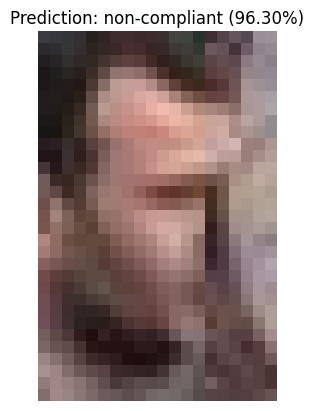

In [13]:
# Function to randomly select an image from the test directory
def get_random_image_from_test_dir(test_dir):
    image_paths = []
    for root, _, files in os.walk(test_dir):
        for file in files:
            if file.endswith(('png', 'jpg', 'jpeg')):
                image_paths.append(os.path.join(root, file))
    return random.choice(image_paths)

# Function for prediction
def predict_image(image_path, model, augment, classes, device):
    transform = get_transforms(augment=augment)
    image = Image.open(image_path).convert('RGB')
    input_tensor = transform(image).unsqueeze(0).to(device)
    model.eval()
    with torch.no_grad():
        outputs = model(input_tensor)
        _, predicted = torch.max(outputs, 1)
        confidence = torch.softmax(outputs, dim=1)[0, predicted.item()].item()
    predicted_class = classes[predicted.item()]
    return predicted_class, confidence, image

# Randomly select an image from the test directory
image_path = get_random_image_from_test_dir(test_dir)

# Classes du dataset
classes = train_dataset.classes

# Predict the class of the image
predicted_class, confidence, image = predict_image(image_path, model, True, classes, device)
print(f"Prediction: {predicted_class} ({confidence*100:.2f}% confidence)")

# Display the image with prediction
plt.imshow(image)
plt.title(f"Prediction: {predicted_class} ({confidence*100:.2f}%)")
plt.axis("off")
plt.show()


# Real time prediction

## Load Model

In [14]:
import cv2
import torch
from torchvision import transforms

# Preprocessing function
preprocess = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Open webcam
cap = cv2.VideoCapture(0)

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Preprocess the frame
    img_tensor = preprocess(frame).unsqueeze(0).to(device)

    # Make predictions
    model.eval()
    with torch.no_grad():
        outputs = model(img_tensor)
        probabilities = torch.softmax(outputs, dim=1)
        confidence, predicted = torch.max(probabilities, 1)

    # Annotate the frame with prediction and confidence
    label = "Mask" if predicted.item() == 0 else "No Mask"
    color = (0, 255, 0) if label == "Mask" else (0, 0, 255)
    text = f"{label} ({confidence.item()*100:.2f}%)"
    cv2.putText(frame, text, (10, 50), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2)

    # Display the frame
    cv2.imshow("Real-Time Mask Detection", frame)

    # Break on 'q' key press
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

cap.release()
cv2.destroyAllWindows()


# Compare MobileNet and EfficientNet

In [16]:
# Initialize models
mobilenet = initialize_model(models.mobilenet_v2, num_classes=len(train_dataset.classes), device=device)
efficientnet = initialize_model(models.efficientnet_b0, num_classes=len(train_dataset.classes), device=device)

# Define training parameters
criterion = nn.CrossEntropyLoss()
lr = 1e-4
batch_size = 32
epochs = 30

# Optimizers
mobilenet_optimizer = optim.Adam(mobilenet.parameters(), lr=lr)
efficientnet_optimizer = optim.Adam(efficientnet.parameters(), lr=lr)

In [17]:
# Train MobileNetV2
mobilenet_metrics, mobilenet_model_path, mobilenet_training_time = train_model(
    mobilenet, train_loader, val_loader, test_loader, criterion, mobilenet_optimizer, epochs, "mobilenetv2", device, use_early_stopping= False
)

size of train_loader : 93, size of val_loader : 24
Training MobileNetV2 for 30 epochs...
Epoch 1/30, Train Loss: 0.3365, Train Accuracy: 85.63%, Train F1: 0.8564, Val Loss: 0.2470, Val Accuracy: 89.77%, Val F1: 0.8979, Time: 59.85s
Epoch 2/30, Train Loss: 0.2218, Train Accuracy: 91.39%, Train F1: 0.9140, Val Loss: 0.2128, Val Accuracy: 90.44%, Val F1: 0.9043, Time: 48.01s
Epoch 3/30, Train Loss: 0.1990, Train Accuracy: 91.99%, Train F1: 0.9200, Val Loss: 0.2101, Val Accuracy: 91.52%, Val F1: 0.9155, Time: 49.63s
Epoch 4/30, Train Loss: 0.1795, Train Accuracy: 92.56%, Train F1: 0.9258, Val Loss: 0.1699, Val Accuracy: 93.81%, Val F1: 0.9382, Time: 48.87s
Epoch 5/30, Train Loss: 0.1490, Train Accuracy: 93.94%, Train F1: 0.9395, Val Loss: 0.1581, Val Accuracy: 93.41%, Val F1: 0.9341, Time: 47.97s
Epoch 6/30, Train Loss: 0.1548, Train Accuracy: 93.37%, Train F1: 0.9338, Val Loss: 0.1656, Val Accuracy: 92.60%, Val F1: 0.9261, Time: 50.05s
Epoch 7/30, Train Loss: 0.1425, Train Accuracy: 94.35

In [18]:
# Train EfficientNet
efficientnet_metrics, efficientnet_model_path, efficientnet_training_time = train_model(
    efficientnet, train_loader, val_loader, test_loader, criterion, efficientnet_optimizer, epochs, "efficientnet", device, use_early_stopping= False
)


size of train_loader : 93, size of val_loader : 24
Training EfficientNet for 30 epochs...
Epoch 1/30, Train Loss: 0.4542, Train Accuracy: 78.30%, Train F1: 0.7820, Val Loss: 0.2932, Val Accuracy: 87.89%, Val F1: 0.8791, Time: 53.46s
Epoch 2/30, Train Loss: 0.2475, Train Accuracy: 90.11%, Train F1: 0.9011, Val Loss: 0.2080, Val Accuracy: 90.71%, Val F1: 0.9072, Time: 53.72s
Epoch 3/30, Train Loss: 0.2086, Train Accuracy: 91.52%, Train F1: 0.9154, Val Loss: 0.1783, Val Accuracy: 93.00%, Val F1: 0.9302, Time: 53.60s
Epoch 4/30, Train Loss: 0.1759, Train Accuracy: 92.87%, Train F1: 0.9287, Val Loss: 0.1744, Val Accuracy: 92.60%, Val F1: 0.9262, Time: 53.13s
Epoch 5/30, Train Loss: 0.1635, Train Accuracy: 93.57%, Train F1: 0.9358, Val Loss: 0.1442, Val Accuracy: 94.62%, Val F1: 0.9462, Time: 52.89s
Epoch 6/30, Train Loss: 0.1464, Train Accuracy: 94.08%, Train F1: 0.9409, Val Loss: 0.1428, Val Accuracy: 95.02%, Val F1: 0.9503, Time: 53.12s
Epoch 7/30, Train Loss: 0.1395, Train Accuracy: 94.8

In [28]:
mobilenet_accuracy = evaluate_model(mobilenet, test_loader)
efficientnet_accuracy = evaluate_model(efficientnet, test_loader)
print(f"MobileNetV2 Accuracy: {mobilenet_accuracy:.2f}%\n")
print(f"EfficientNet Accuracy: {efficientnet_accuracy:.2f}%")

Accuracy: 92.50%
Accuracy: 94.00%
MobileNetV2 Accuracy: 92.50%

EfficientNet Accuracy: 94.00%


In [30]:
model_names = ["mobilenet", "efficientnet"]  # Noms des modèles correspondants

training_times = {
    "mobilenet": mobilenet_training_time,
    "efficientnet": efficientnet_training_time
}

training_metrics = {
    "mobilenet": mobilenet_metrics,
    "efficientnet": efficientnet_metrics
}

test_accuracies = {
    "mobilenet": mobilenet_accuracy,
    "efficientnet": efficientnet_accuracy
}

for model_name in model_names:
    
    metrics = {
        "model_name": model.__class__.__name__,
        "device": str(device),
        "training_time_total": training_times[model_name],  
        "dataset_info": {
            "original_train_dataset_size": len(train_dataset),
            "proportion_used": DATASET_PROPORTION,
            "train_subset_size": len(train_subset),
            "validation_subset_size": len(val_subset),
            "test_subset_size": len(test_subset),
        },
        "model_performance": {
            "test accuracy": test_accuracies[model_name],
            "training_metrics": training_metrics[model_name],
        },
        "training_parameters": {
            "epochs": epochs,
            "batch_size": batch_size,
            "learning_rate": lr,
        }
    }
    
    save_metrics_to_json(metrics, f"models_comparison/{model_name}_metrics.json")

Metrics saved to models_comparison/mobilenet_metrics.json
Metrics saved to models_comparison/efficientnet_metrics.json


In [19]:
# Measure Inference Times
mobilenet_inference_time = measure_inference_time(mobilenet, test_loader, device)
efficientnet_inference_time = measure_inference_time(efficientnet, test_loader, device)

In [22]:
import plotly.graph_objects as go

# Training vs Validation Accuracy
def plot_training_metrics(metrics1, metrics2, model1_name, model2_name):
    epochs = range(1, len(metrics1) + 1)

    fig = go.Figure()
    fig.add_trace(go.Scatter(x=epochs, y=[m["train_accuracy"] for m in metrics1], mode='lines+markers', name=f"{model1_name} Train Accuracy"))
    fig.add_trace(go.Scatter(x=epochs, y=[m["val_accuracy"] for m in metrics1], mode='lines+markers', name=f"{model1_name} Val Accuracy"))
    fig.add_trace(go.Scatter(x=epochs, y=[m["train_accuracy"] for m in metrics2], mode='lines+markers', name=f"{model2_name} Train Accuracy"))
    fig.add_trace(go.Scatter(x=epochs, y=[m["val_accuracy"] for m in metrics2], mode='lines+markers', name=f"{model2_name} Val Accuracy"))
    fig.update_layout(title="Training vs Validation Accuracy", xaxis_title="Epoch", yaxis_title="Accuracy (%)")
    fig.show()

# Training Times
def compare_training_times(time1, time2, model1_name, model2_name):
    fig = go.Figure()
    fig.add_trace(go.Bar(x=[model1_name, model2_name], y=[time1, time2], text=[time1, time2], textposition='outside', name="Training Time"))
    fig.update_layout(title="Training Time Comparison", xaxis_title="Model", yaxis_title="Time (s)")
    fig.show()

# Inference Times
def compare_inference_times(time1, time2, model1_name, model2_name):
    fig = go.Figure()
    fig.add_trace(go.Bar(x=[model1_name, model2_name], y=[time1, time2], text=[time1, time2], textposition='outside', name="Inference Time"))
    fig.update_layout(title="Inference Time Comparison", xaxis_title="Model", yaxis_title="Time (ms per image)")
    fig.show()

# Generate Plots
# plot_training_metrics(mobilenet_metrics, efficientnet_metrics, "MobileNetV2", "EfficientNet")
compare_training_times(mobilenet_training_time, efficientnet_training_time, "MobileNetV2", "EfficientNet")
compare_inference_times(mobilenet_inference_time, efficientnet_inference_time, "MobileNetV2", "EfficientNet")
